In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


# Исследуем "Train.csv"
## Список колонок и краткое их описание:

* row_id: (int64) порядковый номер строки в этой таблице.
* timestamp: (int64) время в миллисекундах между текущим взаимодействием и первым событием связанным с данным ученика.
* user_id: (int32) идентификационный код ученика.
* content_id: (int16) идентификационный код вопроса или лекции.
* content_type_id: (int8) 0 если это вопрос, 1 если лекция.
11
* task_container_id: (int16) идентификационный код группы вопросов, в которой задан текущий вопрос.
* user_answer: (int8) вариант ответа, который выбрал ученик. Всего вариантов может быть 4. В случае если взаимодействие - это лекция, а не вопрос, то данное поле равно -1.
* answered_correctly: (int8) правильно ли ученик ответил на вопрос. В случае, если взаимодействие - это лекция, а не вопрос, то данное поле равно -1. Данное поле нужно будет предсказывать.
* prior_question_elapsed_time: (float32) среднее время в миллисекундах, которое ученику потребовалось, чтобы ответить на все вопросы в предыдущей группе, игнорируя любые лекции между ними. Равен 0 для первой группы вопросов, заданной ученику.
* prior_question_had_explanation: (bool) смотрел ли ученик объяснение и правильный ответ на предыдущий вопрос.


In [8]:
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

df_train = pd.read_csv('Data/train.csv', dtype=dtypes)

In [6]:
display(df_train.head())

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,<NA>
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 boolean
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(2), float32(1), int16(2), int32(1), int64(2), int8(2)
memory usage: 3.2 GB


In [50]:
top_id = df_train['user_id'].value_counts()[:30]

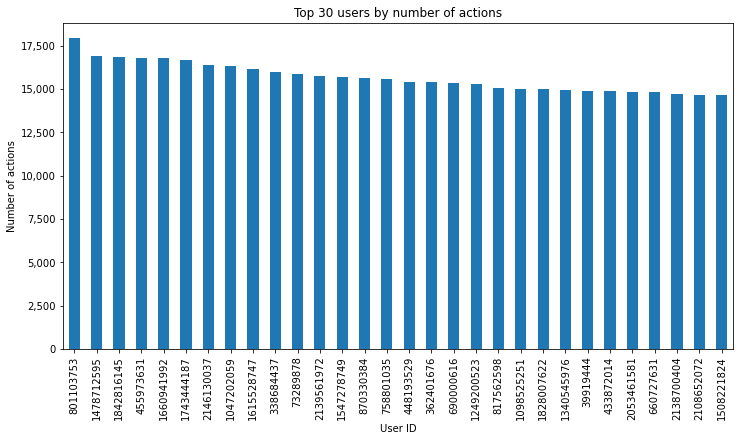

In [54]:
fig = plt.figure(figsize=(12,6))
ax = top_id.plot.bar()
plt.title("Top 30 users by number of actions")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("User ID")
plt.ylabel('Number of actions')
plt.show()

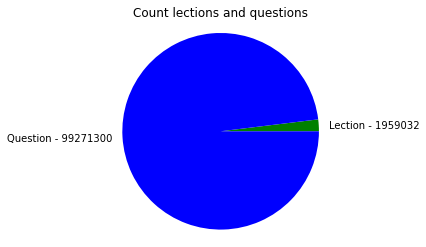

In [69]:
values = []
values.append(df_train['user_answer'].value_counts().iloc[-1])
values.append(df_train.shape[0] - values[0])

labels = ['Lection - ' + str(values[0]),'Question - '+ str(values[1])]
colors = ['green', 'blue']
plt.title("Count lections and questions")
plt.pie(values,labels=labels,colors=colors)
plt.axis('equal')
plt.show()

In [10]:
print(f'We have {df_train.content_id.nunique()} content ids in our train set, of which {df_train[df_train.content_type_id == False].content_id.nunique()} are questions.')

We have 13782 content ids in our train set, of which 13523 are questions.


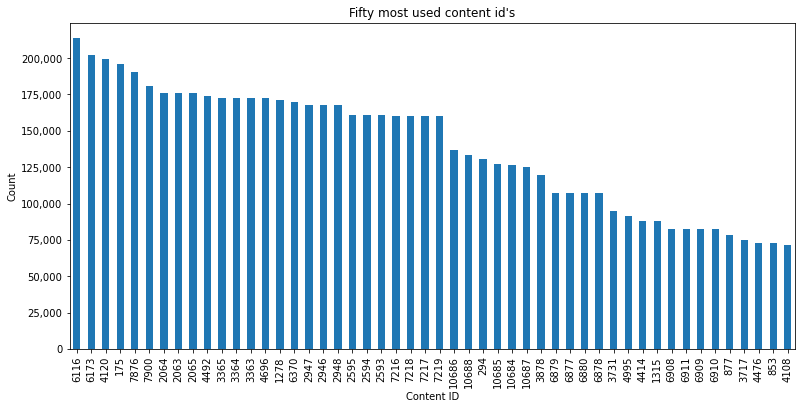

In [56]:
cids = df_train.content_id.value_counts()[:50]

fig = plt.figure(figsize=(13,6))
ax = cids.plot.bar()
plt.title("Fifty most used content id's")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("Content ID")
plt.ylabel('Count')
plt.show()

In [29]:
print(f'We have {df_train.task_container_id.nunique()} unique Batches of questions or lectures.')

We have 10000 unique Batches of questions or lectures.


In [30]:
df_train.user_answer.value_counts()

 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64

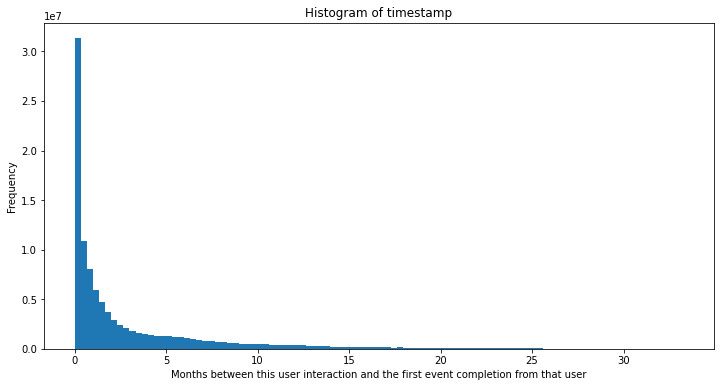

In [32]:
ts = df_train['timestamp']/(31536000000/12)
fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=100)
plt.title("Histogram of timestamp")
plt.xticks(rotation=0)
plt.xlabel("Months between this user interaction and the first event completion from that user")
plt.show()

In [34]:
print(f'Of the {df_train.user_id.nunique()} users in train we have {df_train[df_train.timestamp == 0].user_id.nunique()} users with a timestamp zero row.')

Of the 393656 users in train we have 393656 users with a timestamp zero row.


In [36]:
correct = df_train[df_train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)
print(correct)

0    34026673
1    65244627
Name: answered_correctly, dtype: int64


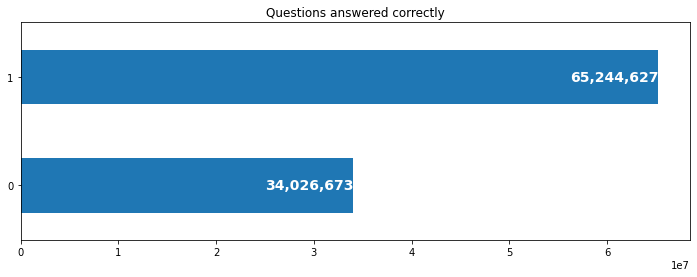

In [39]:
fig = plt.figure(figsize=(12,4))
correct.plot.barh()
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Questions answered correctly")
plt.xticks(rotation=0)
plt.show()

In [52]:
df_train_part_1 = df_train.head(int(df_train.shape[0] / 50)) #1/50 of all data

In [53]:
bin_labels_5 = ['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4', 'Bin_5']
df_train_part_1['ts_bin'] = pd.qcut(df_train_part_1['timestamp'], q=5, labels=bin_labels_5)

C:\Users\pva\AppData\Local\Temp\ipykernel_2472\975260757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_part_1['ts_bin'] = pd.qcut(df_train_part_1['timestamp'], q=5, labels=bin_labels_5)


In [57]:
def correct(field):
    correct = df_train_part_1[df_train_part_1.answered_correctly != -1].groupby([field, 'answered_correctly'], as_index=False).size()
    correct = correct.pivot(index= field, columns='answered_correctly', values='size')
    correct['Percent_correct'] = round(correct.iloc[:,1]/(correct.iloc[:,0] + correct.iloc[:,1]),2)
    correct = correct.sort_values(by = "Percent_correct", ascending = False)
    correct = correct.iloc[:,2]
    return(correct)

bins_correct = correct("ts_bin")
bins_correct = bins_correct.sort_index()

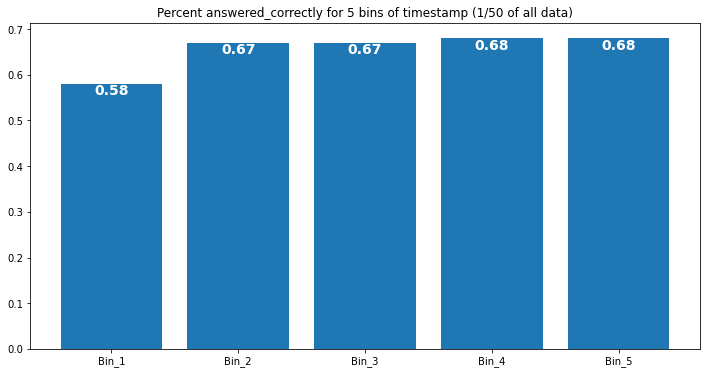

In [59]:
fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct.index, bins_correct.values)
for i, v in zip(bins_correct.index, bins_correct.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.title("Percent answered_correctly for 5 bins of timestamp (1/50 of all data)")
plt.xticks(rotation=0)
plt.show()

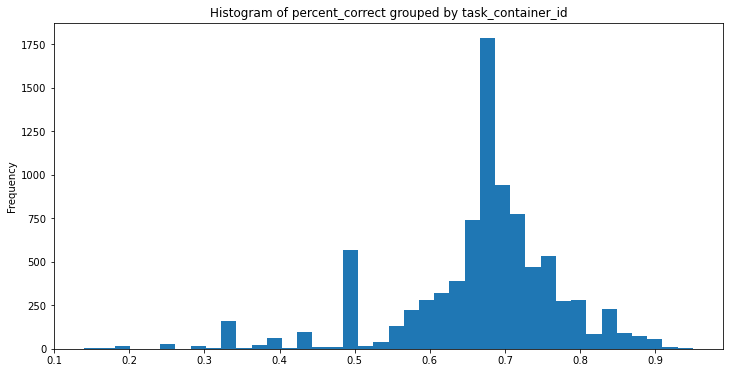

In [60]:
task_id_correct = correct("task_container_id")

fig = plt.figure(figsize=(12,6))
task_id_correct.plot.hist(bins=40)
plt.title("Histogram of percent_correct grouped by task_container_id")
plt.xticks(rotation=0)
plt.show()

In [62]:
user_percent = df_train[df_train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'the highest number of questions answered by a user is {user_percent.Answers.max()}')


the highest number of questions answered by a user is 17609


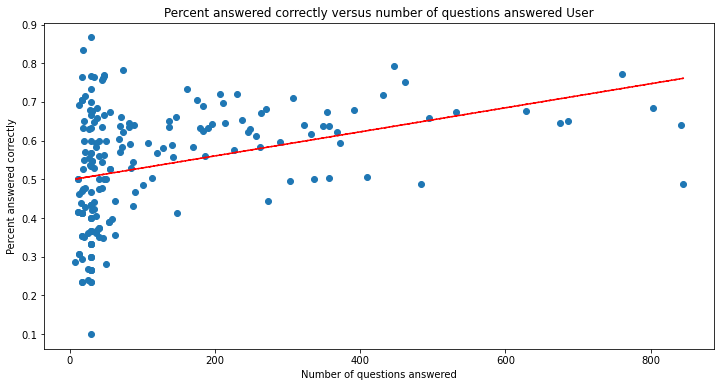

In [65]:
user_percent_1 = user_percent.query('Answers <= 1000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = user_percent_1.Answers
y = user_percent_1.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered User")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

In [73]:
df_train_part_2 = df_train.head(int(df_train.shape[0] / 2)) #1/2 of all data

In [75]:
content_percent = df_train_part_2[df_train_part_2.answered_correctly != -1].groupby('content_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'The highest number of questions asked by content_id is {content_percent.Answers.max()}.')
print(f'Of {len(content_percent)} content_ids, {len(content_percent[content_percent.Answers > 25000])} content_ids had more than 25,000 questions asked.')

The highest number of questions asked by content_id is 105957.
Of 13517 content_ids, 114 content_ids had more than 25,000 questions asked.


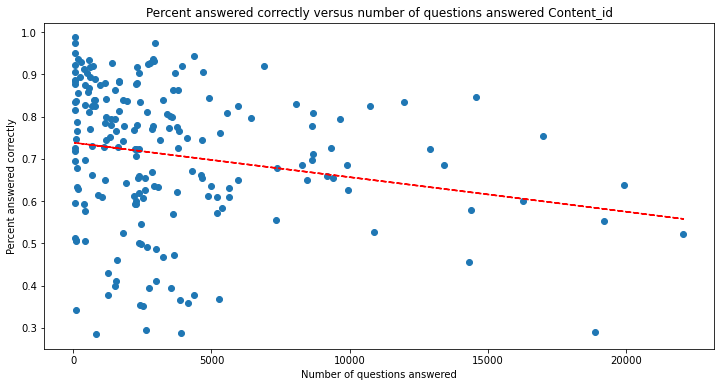

In [76]:
content_percent = content_percent.query('Answers <= 25000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = content_percent.Answers
y = content_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered Content_id")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

#  Исследуем "Questions.csv"
## Список колонок:
* question_id   - внешний ключ(foreign key) для связывание данной информации с таблицей train.
* bundle_id     - код по которому вопросы объединяются в группы.
* correct_answer- правильный ответ на вопрос.
* part          - один из семи типов вопросов TOEIC.
* tags          - один или несколько кодов с тэгами для данного вопроса. Описание тэгов не представлено, но самих кодов достаточно для того, чтобы сделать кластеризацию.


In [5]:
df_questions =  pd.read_csv('Data/questions.csv')
display(df_questions.head())

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [7]:
df_questions[df_questions.tags.isna()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


In [12]:
df_train.query('content_id == 10033 and answered_correctly != -1')

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
62750278,62750278,1286282597,1333688829,10033,False,1127,2,1,35000.0,True


In [13]:
df_questions['tags'] = df_questions['tags'].astype(str)

tags = [x.split() for x in df_questions[df_questions.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f'There are {len(tags)} different tags')

There are 188 different tags


In [14]:
tags_list = [x.split() for x in df_questions.tags.values]
df_questions['tags'] = tags_list
df_questions.head()

correct = df_train[df_train.answered_correctly != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct.columns = ['Wrong', 'Right']
correct = correct.fillna(0)
correct[['Wrong', 'Right']] = correct[['Wrong', 'Right']].astype(int)
questions = df_questions.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")
questions.head()

,question_id,bundle_id,correct_answer,part,tags,Wrong,Right
0,0,0,0,1,"[51, 131, 162, 38]",637,6266
1,1,1,1,1,"[131, 36, 81]",809,6589
2,2,2,0,1,"[131, 101, 162, 92]",20015,24890
3,3,3,0,1,"[131, 149, 162, 29]",5067,17906
4,4,4,3,1,"[131, 5, 162, 38]",12275,19461


In [15]:
questions.tags.values

array([list(['51', '131', '162', '38']), list(['131', '36', '81']),
       list(['131', '101', '162', '92']), ..., list(['73']),
       list(['125']), list(['55'])], dtype=object)

In [16]:
tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions[questions.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({'Wrong': ['sum'], 'Right': ['sum']})
    df1['Total_questions'] = df1.Wrong + df1.Right
    df1['Question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['Wrong', 'Right', 'Total_questions']] = tags_df[['Wrong', 'Right', 'Total_questions']].astype(int)
tags_df['Percent_correct'] = tags_df.Right/tags_df.Total_questions
tags_df = tags_df.sort_values(by = "Percent_correct")

tags_df.head()

C:\Users\pva\AppData\Local\Temp\ipykernel_4840\1870187398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\pva\AppData\Local\Temp\ipykernel_4840\1870187398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\pva\AppData\Local\Temp\ipykernel_4840\1870187398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\pva\AppData\Local\Temp\ipykernel_4840\1870187398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\pva\AppData\Local\Temp\ipykernel_4840\1870187398.py:9: FutureWarning: The f

,Wrong,Right,Total_questions,Question_ids_with_tag,Percent_correct
tag,,,,,
24,157631,98982,256613,17,0.385725
23,261611,204293,465904,11,0.438487
19,173602,136367,309969,57,0.439938
151,272267,264913,537180,16,0.493155
167,170386,170681,341067,11,0.500432


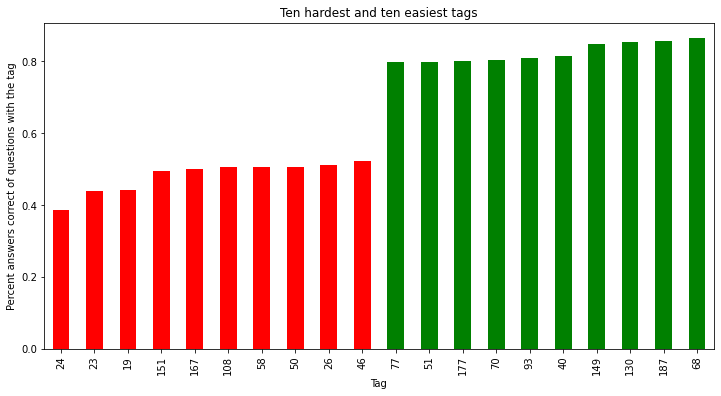

In [17]:
select_rows = list(range(0,10)) + list(range(178, len(tags_df)))
tags_select = tags_df.iloc[select_rows,4]

fig = plt.figure(figsize=(12,6))
x = tags_select.index
y = tags_select.values
clrs = ['red' if y < 0.6 else 'green' for y in tags_select.values]
tags_select.plot.bar(x, y, color=clrs)
plt.title("Ten hardest and ten easiest tags")
plt.xlabel("Tag")
plt.ylabel("Percent answers correct of questions with the tag")
plt.xticks(rotation=90)
plt.show()

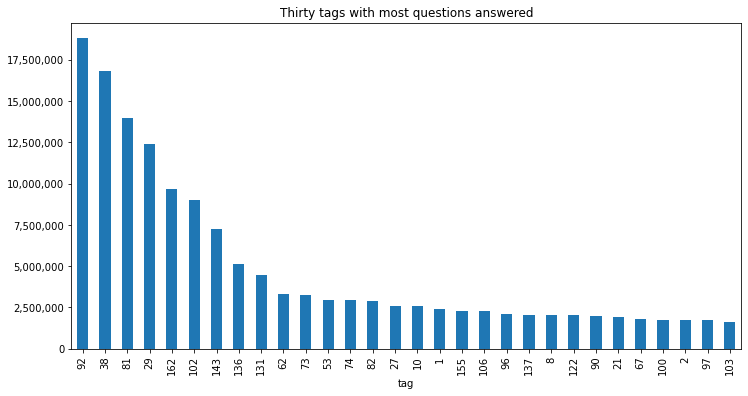

In [18]:
tags_select = tags_df.sort_values(by = "Total_questions", ascending = False).iloc[:30,:]
tags_select = tags_select["Total_questions"]

fig = plt.figure(figsize=(12,6))
ax = tags_select.plot.bar()
plt.title("Thirty tags with most questions answered")
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

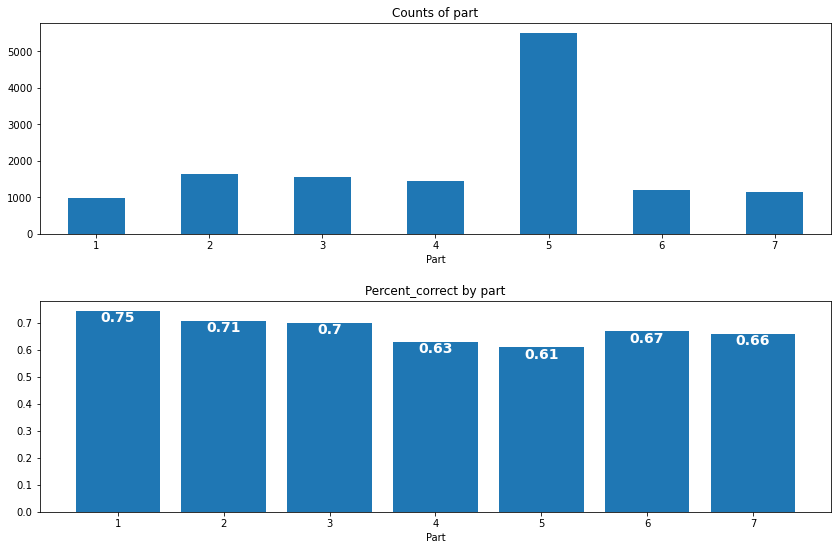

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1 = questions.groupby("part").count()['question_id'].plot.bar()
plt.title("Counts of part")
plt.xlabel("Part")
plt.xticks(rotation=0)

part = questions.groupby('part').agg({'Wrong': ['sum'], 'Right': ['sum']})
part['Percent_correct'] = part.Right/(part.Right + part.Wrong)
part = part.iloc[:,2]

ax2 = fig.add_subplot(212)
plt.bar(part.index, part.values)
for i, v in zip(part.index, part.values):
    plt.text(i, v, round(v,2), color='white', fontweight='bold', fontsize=14, va='top', ha='center')

plt.title("Percent_correct by part")
plt.xlabel("Part")
plt.xticks(rotation=0)
plt.tight_layout(pad=2)
plt.show()

# Исследуем "Lectures.csv"
## Список колонок и краткое их описание:
* lecture_id: внешний ключ(foreign key) для связывание данной информации с таблицей train.
* type_of: краткое описание основной цели лекции.
* part: один из семи типов, который был в таблице с вопросами.
* tag: один тэг в качестве числа, который представляет лекцию, его значение не дано, также как и в вопросах.


In [21]:
df_lectures = pd.read_csv('data/lectures.csv')
df_lectures.head(10)

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
5,335,114,2,concept
6,484,179,5,concept
7,641,134,6,solving question
8,761,93,1,concept
9,814,80,5,solving question


In [22]:
df_lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [24]:
lect_type_of = df_lectures['type_of'].value_counts()
display(lect_type_of)

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

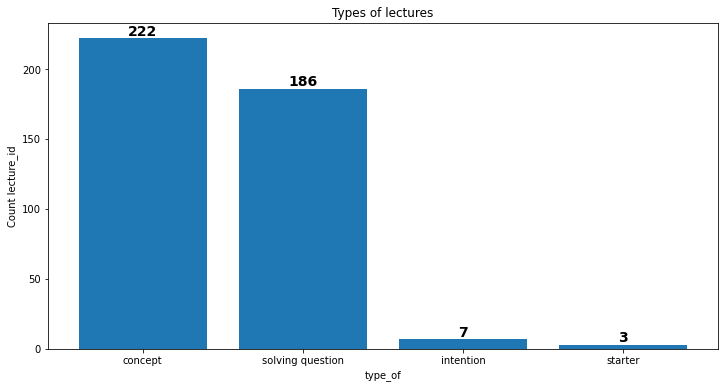

In [26]:
fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("Types of lectures")
plt.xlabel("type_of")
plt.ylabel("Count lecture_id")
plt.xticks(rotation=0)
plt.show()

False    244050
True     149606
Name: Watches_lecture, dtype: int64


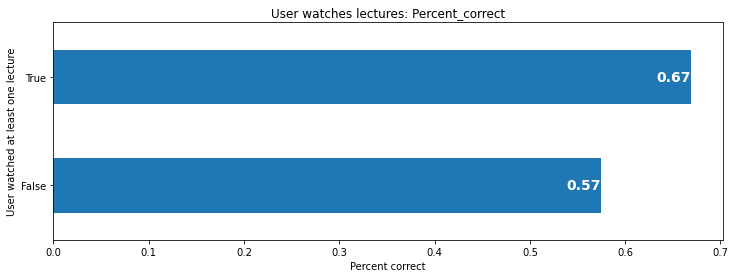

In [27]:
user_lect = df_train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']})
print(user_lect.Watches_lecture.value_counts())

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)

watches_l = watches_l.iloc[:,2]

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("User watches lectures: Percent_correct")
plt.xlabel("Percent correct")
plt.ylabel("User watched at least one lecture")
plt.xticks(rotation=0)
plt.show()

In [28]:
batch_lect = df_train.groupby(["task_container_id", "answered_correctly"]).size().unstack()
batch_lect.columns = ['Lecture', 'Wrong', 'Right']
batch_lect['Lecture'] = batch_lect['Lecture'].fillna(0)
batch_lect = batch_lect.astype('Int64')
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect['Percent_lecture'] = batch_lect.Lecture/(batch_lect.Lecture + batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect.sort_values(by = "Percent_lecture", ascending = False)

print(f'The highest number of lectures watched within a single task_container_id is {batch_lect.Lecture.max()}.')

The highest number of lectures watched within a single task_container_id is 5143.


In [29]:
batch_lect.head()

,Lecture,Wrong,Right,Percent_correct,Percent_lecture
task_container_id,,,,,
9096,8,57,191,0.770161,0.03125
270,2265,26105,52352,0.66727,0.028059
477,1428,16166,33427,0.674027,0.027988
253,2343,27380,54798,0.666821,0.027721
351,1835,21225,43158,0.670332,0.027711


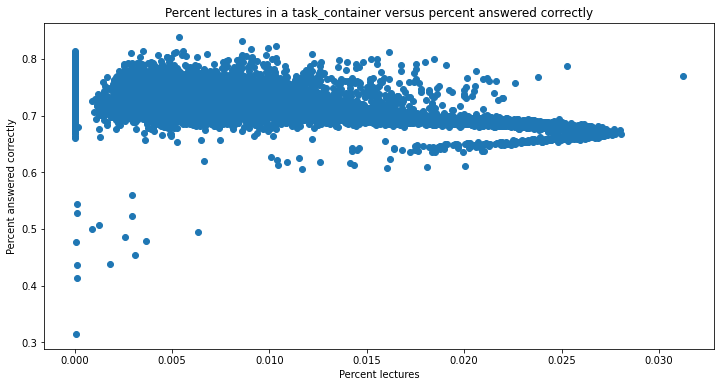

In [31]:
batch = batch_lect.iloc[:, 3:]

fig = plt.figure(figsize=(12,6))
x = batch.Percent_lecture
y = batch.Percent_correct
plt.scatter(x, y, marker='o')
plt.title("Percent lectures in a task_container versus percent answered correctly")
plt.xticks(rotation=0)
plt.xlabel("Percent lectures")
plt.ylabel("Percent answered correctly")

plt.show()